# Neural Network to Classify MNIST Digits

### Imports

In [8]:
import os
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Load Test Data

In [9]:
mnist = input_data.read_data_sets("MNIST Data/", one_hot=True)
print(f"Training set size: {mnist.train.num_examples}")
print(f"Test set size: {mnist.test.num_examples}")
print(f"Validation set size: {mnist.validation.num_examples}")
image = mnist.train.images[0]
print(f"Image is of type {type(image)} and shape {image.shape}")
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(f"Shape of Keras' training set: {train_images.shape}.")
print(f"Shape of Keras' test set: {test_images.shape}.")

Extracting MNIST Data/train-images-idx3-ubyte.gz
Extracting MNIST Data/train-labels-idx1-ubyte.gz
Extracting MNIST Data/t10k-images-idx3-ubyte.gz
Extracting MNIST Data/t10k-labels-idx1-ubyte.gz
Training set size: 55000
Test set size: 10000
Validation set size: 5000
Image is of type <class 'numpy.ndarray'> and shape (784,)
Shape of Keras' training set: (60000, 28, 28).
Shape of Keras' test set: (10000, 28, 28).


### Display Sample Images

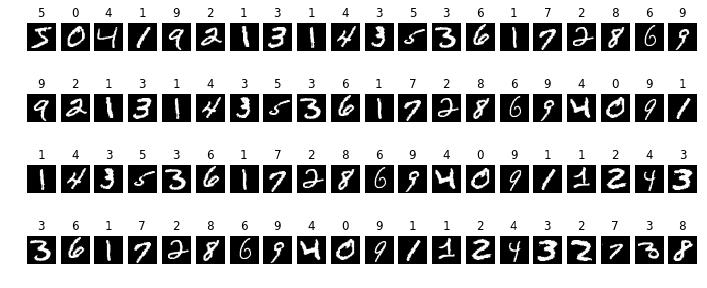

In [10]:
rows = 4
cols = 20
f, axes = plt.subplots(rows, cols, figsize=(12,5)) # image size is in inches
for i in range(rows):
    for j in range(cols):
        index = i*rows + j
        axes[i, j].imshow(train_images[index, :, :], cmap='gray')
        axes[i, j].set_title(f"{train_labels[index]}")
        axes[i, j].axis('off')
plt.show()

Label = 3
............................
............................
............................
............................
............................
.............+++++++........
...........++++++++++.......
..........+++++++++++.......
..........++++++..+++.......
.........++++++++..+++......
..........++..+++.++++......
..............+++++++.......
...........++++++++++.......
...........+++++++++........
...........++++++++.........
...........+++++++..........
..............+++++.........
......+.........+++.........
.....+++........+++.........
....+++........++++.........
....+++.......+++++.........
....+++++..+++++++..........
.....+++++++++++++..........
.....+++++++++++............
......++++++++..............
............................
............................
............................


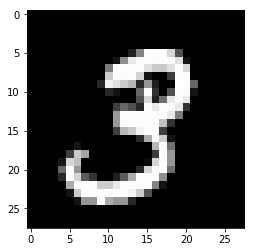

In [13]:
# Display one of the images from the legacy set
image = mnist.train.images[1]
label = mnist.train.labels[1]
print("Label =", label.argmax())
pixels = image.reshape((28, 28)) # reinterpret 784x1 array as a 28x28 array
# Display in text mode
for row in pixels:
    print(''.join([ '+' if val != 0 else '.' for val in row ]))
# Display as picture
plt.imshow(pixels, cmap='gray');

In [14]:
# Function to attach summaries to a tensor
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [15]:
# Set up graph
with tf.name_scope('Inputs'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='image') # Nx784
    y = tf.placeholder(tf.float32, shape=[None, 10], name='label')  # Nx10
with tf.name_scope('LinearModel'):
    W = tf.Variable(tf.zeros([784, 10]), name='weights')  # 784x10
    b = tf.Variable(tf.zeros([10]), name='bias') # 1x10
    y_hat = tf.matmul(x, W) + b # Nx10
    variable_summaries(y_hat)

with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_hat, name='softmax'))
    tf.summary.scalar('loss', loss)
with tf.name_scope('Optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
summarize_all = tf.summary.merge_all()

# Accuracy calculation
is_correct = tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1)) # compare index of entry with largest value
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32)) # compute % of correct predictions

In [16]:
start_time = time.time()
init = tf.global_variables_initializer()
num_iterations = 1000
batch_size = 100
log_path = './TBLogs/'
with tf.Session() as sess:
    tbWriter = tf.summary.FileWriter(log_path, sess.graph)
    sess.run(init)    
    for i in range(num_iterations):
        # Retrieve images and labels as [batch_size, 784] and [batch_size, 10] arrays
        images, labels = mnist.train.next_batch(batch_size)
        _, summary = sess.run([optimizer, summarize_all], feed_dict={x:images, y:labels})
        tbWriter.add_summary(summary, i)
        if (i % 100 == 0) or (i == num_iterations-1):
            l = sess.run(loss, feed_dict={x:images, y:labels})
            end_time = time.time()
            acc = sess.run(accuracy, feed_dict={y:labels, x:images})
            print(f"Step {i} complete after {end_time-start_time:.1f}s, with loss {l:.2f} and training accuracy {acc*100:.1f}%.")
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:mnist.test.images, y:mnist.test.labels})
    print(f"Accuracy on test data: {acc*100:.1f}%.")
    tbWriter.close()
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.1f}s.")

Step 0 complete after 0.7s, with loss 1.67 and training accuracy 49.0%.
Step 100 complete after 0.8s, with loss 0.27 and training accuracy 95.0%.
Step 200 complete after 0.9s, with loss 0.40 and training accuracy 84.0%.
Step 300 complete after 1.0s, with loss 0.28 and training accuracy 94.0%.
Step 400 complete after 1.1s, with loss 0.24 and training accuracy 95.0%.
Step 500 complete after 1.2s, with loss 0.31 and training accuracy 92.0%.
Step 600 complete after 1.5s, with loss 0.36 and training accuracy 92.0%.
Step 700 complete after 1.6s, with loss 0.39 and training accuracy 89.0%.
Step 800 complete after 1.7s, with loss 0.20 and training accuracy 96.0%.
Step 900 complete after 1.8s, with loss 0.29 and training accuracy 93.0%.
Step 999 complete after 1.9s, with loss 0.20 and training accuracy 94.0%.
Accuracy on test data: 91.4%.
Elapsed time: 2.1s.


## Check prediction on image from test set

Output = [[-8.339703    0.37877756 -1.5996735  -0.4016207   2.251695    1.6011606
  -1.9917777   0.66464436  1.3039792   6.1325035 ]]
Probabilities = [[4.9434976e-07 3.0228887e-03 4.1801491e-04 1.3851586e-03 1.9670699e-02
  1.0263521e-02 2.8242497e-04 4.0232083e-03 7.6248641e-03 9.5330876e-01]]
Predicted value = 9
Correct value = 9


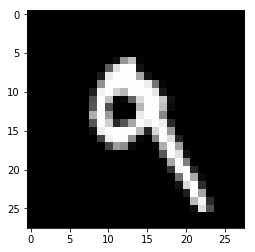

In [17]:
# Perform prediction on test data
import numpy as np
index = 7
image = np.expand_dims(mnist.test.images[index], axis=0)
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray');
output = np.matmul(image, weights) + bias
probabilities = np.exp(output) / np.exp(output).sum()
print("Output =", output)
print("Probabilities =", probabilities)
print("Predicted value =", output.argmax())
print("Correct value =", mnist.test.labels[index].argmax())